# Paris NWP runs from polytope
Example for how to extract model level data from polytope and create profiles.

To explore all data available visit https://catalogue.lumi.apps.dte.destination-earth.eu/?class=d1&dataset=on-demand-extremes-dt&expver=aab0&stream=oper

In [1]:
# Import necessary libraries
import earthkit.data
import earthkit.plots
import matplotlib.pyplot as plt

from versions import UrbanAirData

version = "7.1"
uad = UrbanAirData().urls[version]

In [2]:
# Client authentification, use if required
#from polytope.api import Client
#client = Client(address=polytope_address)

In [3]:
# Define the request, note that we only extract levtop -> 90 levels to reduce the data amount
levtop = 70
request= {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "expver": uad["metadata"]["fdb"]["expver"],
    "stream": "oper",
    "date": uad["metadata"]["date"][:10],
    "time": uad["metadata"]["date"][12:18].replace(":",""),
    "type": "fc",
    "georef": uad["metadata"]["fdb"]["georef"],
    "levtype": "ml",
    "step": "1",
    "levelist": f"{levtop}/to/90",
    "expect" : 0,
    # z,t,u,v,q,w
    "param": ["129", "130", "131", "132", "133", "260238"],
}

In [4]:
# Rune the request
data = earthkit.data.from_source("polytope", uad["metadata"]["polytope"]["collection"], request, address=uad["metadata"]["polytope"]["url"], stream=False)
data.ls()

2026-03-01 20:07:07 - INFO - Key read from /home/snh/.polytopeapirc
2026-03-01 20:07:07 - INFO - Sending request...
{'request': 'class: d1\n'
            'dataset: on-demand-extremes-dt\n'
            "date: '2023-08-20'\n"
            'expect: 0\n'
            'expver: aabg\n'
            'georef: u09tvk\n'
            'levelist: 70/to/90\n'
            'levtype: ml\n'
            'param:\n'
            "- '129'\n"
            "- '130'\n"
            "- '131'\n"
            "- '132'\n"
            "- '133'\n"
            "- '260238'\n"
            "step: '1'\n"
            'stream: oper\n'
            "time: '0000'\n"
            'type: fc\n',
 'verb': 'retrieve'}
2026-03-01 20:07:07 - INFO - Polytope user key found in session cache for user snh
2026-03-01 20:07:07 - INFO - Request accepted. Please poll ./4db82126-d1de-4c4a-a3ce-e497e56d39c0 for status
2026-03-01 20:07:07 - INFO - Polytope user key found in session cache for user snh
2026-03-01 20:07:07 - INFO - Checking request statu

4db82126-d1de-4c4a-a3ce-e497e56d39c0.grib:   0%|          | 0.00/147M [00:00<?, ?B/s]

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,hybrid,70,20230820,0,1,fc,None,lambert_lam
1,ecmf,t,hybrid,70,20230820,0,1,fc,None,lambert_lam
2,ecmf,u,hybrid,70,20230820,0,1,fc,None,lambert_lam
3,ecmf,v,hybrid,70,20230820,0,1,fc,None,lambert_lam
4,ecmf,q,hybrid,70,20230820,0,1,fc,None,lambert_lam
...,...,...,...,...,...,...,...,...,...,...
121,ecmf,t,hybrid,90,20230820,0,1,fc,None,lambert_lam
122,ecmf,u,hybrid,90,20230820,0,1,fc,None,lambert_lam
123,ecmf,v,hybrid,90,20230820,0,1,fc,None,lambert_lam
124,ecmf,q,hybrid,90,20230820,0,1,fc,None,lambert_lam


In [5]:
# Convert to xarray
atm = data.sel({"typeOfLevel": "hybrid"}).to_xarray()
atm

<xarray.Dataset> Size: 1GB
Dimensions:    (level: 21, y: 989, x: 989)
Coordinates:
  * level      (level) int64 168B 70 71 72 73 74 75 76 ... 84 85 86 87 88 89 90
    latitude   (y, x) float64 8MB ...
    longitude  (y, x) float64 8MB ...
Dimensions without coordinates: y, x
Data variables:
    q          (level, y, x) float64 164MB ...
    t          (level, y, x) float64 164MB ...
    u          (level, y, x) float64 164MB ...
    v          (level, y, x) float64 164MB ...
    wz         (level, y, x) float64 164MB ...
    z          (level, y, x) float64 164MB ...
Attributes:
    class:        d1
    stream:       oper
    levtype:      ml
    type:         fc
    expver:       aabg
    date:         20230820
    time:         0
    domain:       g
    Conventions:  CF-1.8
    institution:  ECMWF

In [6]:
# Extract the different parameters
g = 9.81
t = atm.t.data
q = atm.q.data
z = atm.z.data /g
w = atm.wz.data

Text(0, 0.5, 'Altitude (m)')

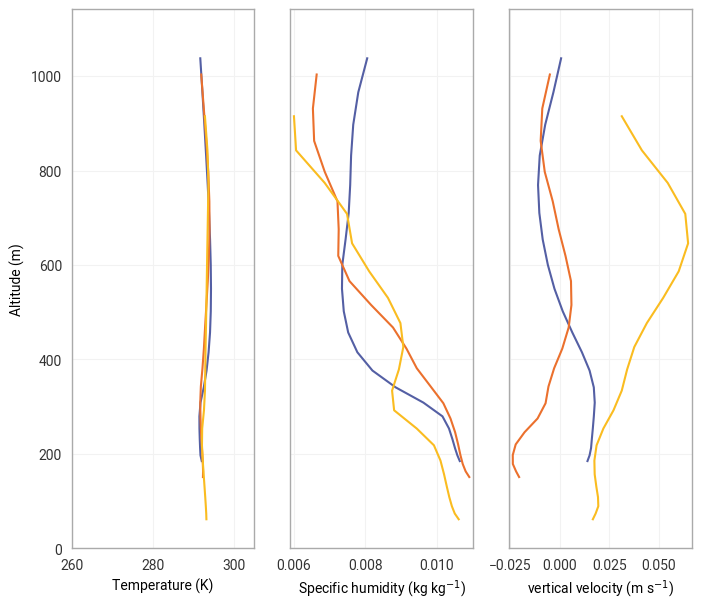

In [7]:
# Plot profiles for some gridpoints, will be improved by defining specific lat,lon values

ztop = 0

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
for x in [30,70,100]:
  ztop = max(z[::-1, x, x].max(),ztop)
  ax1.plot(t[::-1, x, x], z[::-1, x, x])
  ax2.plot(q[::-1, x, x], z[::-1, x, x])
  ax3.plot(w[::-1, x, x], z[::-1, x, x])

ax1.set_ylim(0, ztop*1.1)
ax1.set_xlim(260, 305)
ax1.set_xlabel("Temperature (K)")
ax2.set_xlabel(r"Specific humidity (kg kg$^{-1}$)")
ax3.set_xlabel(r"vertical velocity (m s$^{-1}$)")
ax1.set_ylabel("Altitude (m)")